In [1]:
import pandas as pd
import numpy as np
import requests

In [6]:
import requests

url = "https://data.cityofnewyork.us/resource/3q43-55fe.json"

params = {
    "$limit": 300000,  # Number of records
    "complaint_type": "Rodent",
    "city": "BROOKLYN"
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()

    print(f"Retrieved {len(data)} records.")
else:
    print(f"Failed to retrieve data: {response.status_code}")


Retrieved 96040 records.


In [7]:
complaints_data = pd.DataFrame(data)
complaints_data['created_date'] = pd.to_datetime(complaints_data['created_date'])
complaints_data['zipcode'] = complaints_data['incident_zip'].astype(str)
complaints_data['month'] = complaints_data['created_date'].dt.to_period('M')

In [8]:
rodent_counts = complaints_data.groupby(['zipcode', 'month']).size().reset_index(name='rodent_complaints')

In [9]:
params = {
    "$limit": 300000,  # Number of records
    "boro" : "Brooklyn"
}

In [10]:
url_health = "https://data.cityofnewyork.us/resource/43nn-pn8j.json"
response_health = requests.get(url_health, params = params)
health_data = pd.DataFrame(response_health.json())

In [11]:
health_data['score'] = pd.to_numeric(health_data['score'], errors='coerce')
health_data['zipcode'] = health_data['zipcode'].astype(str)
health_data['inspection_date'] = pd.to_datetime(health_data['grade_date'])
health_data['month'] = health_data['inspection_date'].dt.to_period('M')
health_data['key'] = health_data['dba'] + health_data['building']

In [12]:
violations = (
    health_data
    .groupby(['key', 'month', 'violation_code'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

In [13]:
zips = health_data[['key', 'zipcode']].drop_duplicates()

In [14]:
health_data_agg = health_data.groupby(['key', 'month']).agg({'score': 'mean'}).reset_index()
health_data_agg = health_data_agg.merge(violations, on=['key', 'month'], how='left')
health_data_agg.sort_values(by=['key', 'month'], inplace=True)

In [16]:
counts = health_data_agg.groupby(['key']).agg({'score': 'count'}).reset_index()

In [17]:
keys = list(counts[counts.score >= 2].key)

In [18]:
health_data_agg = health_data_agg[health_data_agg.key.isin(keys)]

In [19]:
violation_cols = ['10F', '04M', '08A', '09A', '09C', '03A',
       '06A', '06C', '02G', '04L', '06D', '02B', '08B', '06F', '10E', '04D',
       '02H', '04H', '04K', '04O', '10H', '04N', '10B', '04A', '10G', '09B',
       '05D', '10A', '06B', '06E', '10I', '02I', '08C', '28-06', '28-05',
       '09E', '04J', '02A', '04C', '05H', '10D', '02C', '03B', '10C', '03E',
       '03I', '03C', '10J', '02D', '04P', '05B', '05F', '04E', '05A', '05E',
       '06G', '07A', '09D', '04F', '05C', '02F', '04B', '22G', '28-07']

In [20]:
for lag in range(1, 4):
    health_data_agg[f'score_lag{lag}'] = (
        health_data_agg.groupby('key')['score']
          .shift(lag)
    )

    for vc in violation_cols:
          health_data_agg[f'{vc}_lag{lag}'] = (
              health_data_agg
                .groupby('key')[vc]
                .shift(lag)
          )

<ipython-input-20-97f5c55eeb98>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  health_data_agg[f'{vc}_lag{lag}'] = (
<ipython-input-20-97f5c55eeb98>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  health_data_agg[f'{vc}_lag{lag}'] = (
<ipython-input-20-97f5c55eeb98>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

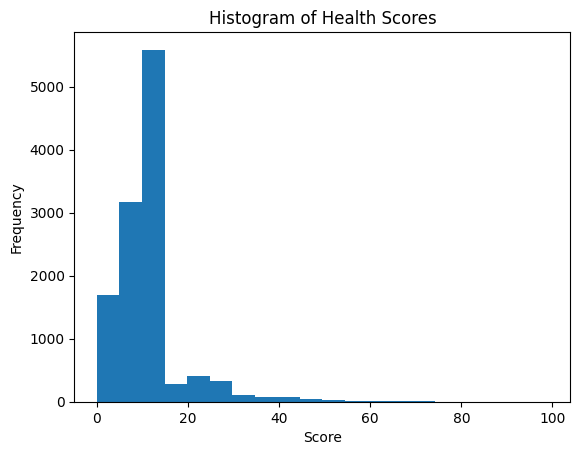

In [21]:
# prompt: Plot histogram of health_data_agg.score

import matplotlib.pyplot as plt

# Assuming health_data_agg is already defined as in your provided code
plt.hist(health_data_agg.score, bins=20) # Adjust the number of bins as needed
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Health Scores')
plt.show()


In [22]:
health_data_agg['pred'] = 0
health_data_agg.loc[(health_data_agg['04L'] > 0) | (health_data_agg['04K'] > 0), 'pred'] = 1
health_data_agg.drop(columns = violation_cols, inplace = True)
health_data_agg = health_data_agg[health_data_agg.score_lag1.notna()]
health_data_agg = health_data_agg.merge(zips, on = 'key')
health_data_agg = health_data_agg.merge(rodent_counts, on = ['zipcode', 'month'], how = 'left')
health_data_agg.drop(columns = 'zipcode', inplace = True)
# health_data_agg.loc[health_data_agg.score > 20, 'pred'] = 1

health_data_agg.drop(columns = 'score', inplace = True)

<ipython-input-22-3388c0bc0026>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  health_data_agg['pred'] = 0


In [23]:
health_data_agg.pred.value_counts()

,count
pred,
0,6118
1,1052


***XGBoost***

In [24]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

In [25]:
X = health_data_agg.drop(['key', 'month', 'pred'], axis=1)
y = health_data_agg['pred']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

In [29]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=10,
)

In [30]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:51:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.66884	validation_1-auc:0.59233
[1]	validation_0-auc:0.70245	validation_1-auc:0.62140
[2]	validation_0-auc:0.71301	validation_1-auc:0.63201
[3]	validation_0-auc:0.71971	validation_1-auc:0.62006
[4]	validation_0-auc:0.72941	validation_1-auc:0.62714
[5]	validation_0-auc:0.73248	validation_1-auc:0.63073
[6]	validation_0-auc:0.73457	validation_1-auc:0.63007
[7]	validation_0-auc:0.73746	validation_1-auc:0.63049
[8]	validation_0-auc:0.73856	validation_1-auc:0.62961
[9]	validation_0-auc:0.73987	validation_1-auc:0.62641
[10]	validation_0-auc:0.74269	validation_1-auc:0.62806
[11]	validation_0-auc:0.74540	validation_1-auc:0.62773


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [32]:
y_pred  = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

ROC AUC: 0.6320125272331154
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1224
           1       0.22      0.45      0.30       210

    accuracy                           0.69      1434
   macro avg       0.55      0.59      0.55      1434
weighted avg       0.79      0.69      0.73      1434



***Balnaced RF***

In [33]:

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

brf = BalancedRandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    sampling_strategy='auto',
    random_state=42,
    n_jobs=-1
)


brf.fit(X_train, y_train)

y_pred  = brf.predict(X_test)
y_proba = brf.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


ROC AUC: 0.6236655773420479

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80      1224
           1       0.22      0.42      0.29       210

    accuracy                           0.69      1434
   macro avg       0.55      0.58      0.55      1434
weighted avg       0.78      0.69      0.73      1434

